In [1]:
# pip install transformers
# pip install seqeval
# pip install pandas
# pip install numpy
# pip install matplotlib
# pip install seaborn
# !pip install scikit-learn
# !pip install torch torchvision
# !pip install nltk
# !pip install  spacy
# !pip install scipy
# !pip install yellowbrick
# !pip install tqdm
# !pip install openpyxl
# !pip install nlpaug

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import transformers
import torch
from transformers import BertTokenizer
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader, random_split, Dataset
from transformers import BertTokenizer, BertModel, BertConfig
import numpy as np
import torch.nn as nn
from sklearn import metrics

In [3]:
path="/content/final data.xlsx"
data=pd.read_excel(path)
data.sample(10)

,sentence,intent
164,Mark node ID 456 as 'activated' with the prope...,add property
152,"Get rid of this node, I don't want it anymore!",delete node
299,I'd like to connect the 'Product' and 'Categor...,add relationship
45,Could you please make a node with the label 'P...,add node
277,Could you create a 'SIMILAR_TO' relationship b...,add relationship
177,"add the next set of properties: languages, ski...",add property
241,I need to establish a 'FRIEND_OF' relationship...,add relationship
38,Can you create a node with the label 'Desert'.,add node
148,It would be great if you could remove the elem...,delete node
90,Please erase the node with the website 'www.ex...,delete node


In [4]:
import logging
logging.getLogger("transformers").setLevel(logging.ERROR)

### DATA EXPLORATION

In [5]:
print("Total number of instances:")
print(len(data))

Total number of instances:
314


Text(0.5, 1.0, 'Distribution of data among classes in dataset.')

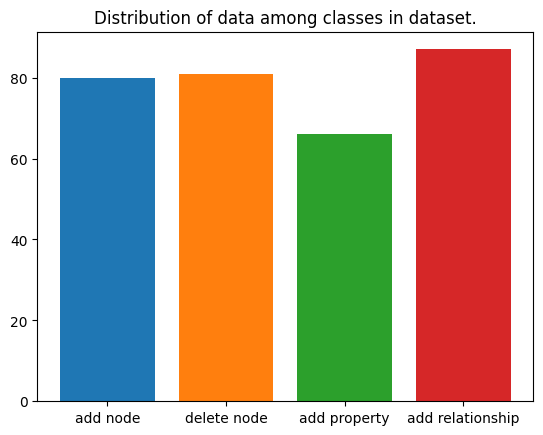

In [6]:
classes=data['intent'].unique()
countDict={}
for Class in classes:
    countDict[Class]=data['intent'].value_counts().get(Class,0)
for Class,count in countDict.items():
    plt.bar(Class,count)
plt.title('Distribution of data among classes in dataset.')

Since the distribution of data among the classes is not too imbalanced, we do not need to perform normalization.

### DATA PRE-PROCESSING

As BERT is trained on a corpus of full sentences of natural language and the embedding process involves contextual embedding, performing stop-word removal might interfere with the accurate functioning of BERT. So we do not remove stop words from our input. This is also why we will not be performing stemming or lemmatization.

removing all punctuation marks except '' and "" as the specifics of graph manipulation are expected to be input in quotes.

In [7]:
import string
def removePunctuation(sentence):
    cleaned="".join([char for char in sentence if char not in string.punctuation or char=="'" or char=='"'])
    return cleaned

In [8]:
data['sentence'] =data['sentence'].apply(removePunctuation) #remove punctuation from data

convert all classes to numerical classes <br>

In [9]:
ClassNumber=0
for Class in data['intent'].unique():
    print(f'Class name:{Class}-->number: {ClassNumber}')
    data['intent']=data['intent'].replace(Class,ClassNumber)
    ClassNumber+=1

Class name:add node-->number: 0
Class name:delete node-->number: 1
Class name:add property-->number: 2
Class name:add relationship-->number: 3


In [10]:
data.sample(10)

,sentence,intent
273,I need to establish a 'SIMILARTO' relationship...,3
54,Add a node for the concept of 'Love',0
82,Please eliminate node 1010 from the graph,1
265,Is it possible to add a 'MEMBEROF' relationshi...,3
199,Set the property 'status 'active' 'engaged'' o...,2
176,update the node with these properties gender o...,2
104,Delete the node representing the object with I...,1
170,I'm telling you you need to add the damn prope...,2
290,I'd like to connect the 'City' and 'Country' n...,3
245,I need to establish a 'SUPPLIEROF' relationshi...,3


**PRE-PROCESSING FOR BERT** <br>
1. [CLS] and [SEP] are special tokens that BERT requires. this is because BERT was orginally trained for Q-A tasks. For classfn tasks, BERT requires another special token. All of these tokens are in-built in the hugging face tokenizer.
2. All sequences must be of the same length, so we need to do padding. We do the padding on the right side which is preferred for BERT.
3. Finally we pass in attention mask to assign importance to each token. So all non-padding tokens are assigned an attention of 1 and padding tokens 0.
<br><br>
<i>Since BERT takes the input ids, attention mask and target classes as 3 separate outputs, we can create a dataset where each of them are a separate column to make our program more readable.<i>

Hugging face's BERT tokenizer uses pre trained BERT base, a small version of BERT. we use cased BERT because we want our model to be case sensitive, which will be important for paramter extraction in the named entity recognition layer.

In [11]:
def preProcess(data):
    tokenizer=BertTokenizer.from_pretrained('bert-base-cased')
    input_ids_list=[]
    attention_masks_list=[]
    intents_list=[]
    for sentence,label in zip(data['sentence'],data['intent']):
        encoding=tokenizer.encode_plus(
            sentence,
            add_special_tokens= True,
            padding='max_length',
            return_attention_mask=True,
            return_token_type_ids=False,
            return_tensors='pt' #pt signifies pyTorch, use tf for tensorFlow & keras
        )
        input_ids_list.append(encoding['input_ids'])
        attention_masks_list.append(encoding['attention_mask'])
        intents_list.append(torch.tensor(label).long()) #most transformer models and BERT expect input data to be of the type LongTensor
    #to ensure that all of our tensors have the same shape we use cat()
    input_ids_list = torch.cat(input_ids_list)
    attention_masks_list = torch.cat(attention_masks_list)
    intents_list = torch.stack(intents_list)
    dataset=TensorDataset(input_ids_list,attention_masks_list,intents_list)
    return dataset

In [12]:
dataset=preProcess(data)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [13]:
# for i in range(1):
#     input_ids, attention_mask, intent = dataset[i]
#     print(f"Input IDs: {input_ids}")
#     print(f"Attention Mask: {attention_mask}")
#     print(f"Intent: {intent}")
#     print()

### TRAINING AND MODEL ARCHITECTURE

Creating train and test sets with dataloader

In [14]:
train_percent=0.8
test_percent=0.2
train_data,test_data=random_split(dataset,[train_percent,test_percent])

In [15]:
#we do not have to define custom dataset with Dataset class as we've used TensorDataset() on our data.
bSize=4
trainingData=DataLoader(train_data,batch_size=bSize,shuffle=True)
testingData=DataLoader(test_data,batch_size=bSize,shuffle=True)

In [16]:
print("Training data format:")
for batch in enumerate(trainingData):
    _,tensor=batch
    print(tensor)
    # for i in range(bSize):
    #     input_ids = tensor[0][i]
    #     attention_mask = tensor[1][i]
    #     labels = tensor[2][i]
    #     print(f'BATCH ELEMENT {i}---------------------')
    #     print("Input IDs:", input_ids)
    #     print("Attention Mask:", attention_mask)
    #     print("Labels:", labels)
    break

Training data format:
[tensor([[  101,  9352, 16618,  ...,     0,     0,     0],
        [  101, 24930,  1181,  ...,     0,     0,     0],
        [  101,  7426,  1128,  ...,     0,     0,     0],
        [  101,  2181,  1122,  ...,     0,     0,     0]]), tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), tensor([1, 2, 1, 0])]


In [17]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

Define loss function and optimizer

In [18]:
loss_fn = torch.nn.CrossEntropyLoss()
def GetOptimizer(model):
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-4)
    return optimizer

TRAINING LOOP

In [19]:
def train(epochs,model):
    lossList=[]
    for epoch in range(epochs):
        model.train()
        epoch_loss=0
        for _,inputs in enumerate(trainingData):
            ip_ids=inputs[0].to(device)
            mask=inputs[1].to(device)
            target=inputs[2].to(device)

            GetOptimizer(model).zero_grad()
            predictions=model(ip_ids,mask)
            loss=loss_fn(predictions,target)
            loss.backward()
            GetOptimizer(model).step()

            epoch_loss+=loss
        average_loss_per_epoch=epoch_loss/len(trainingData)
        lossList.append(average_loss_per_epoch.item())
        if epoch%10==0 or epoch==epochs-1:
            print(f"{epoch} epoch: loss ={loss}")
    return lossList

EVALUATION OF MODEL OUTPUT

In [80]:
def evaluate(model):
  final_targets=[]
  final_predictions=[]
  model.eval()
  for _,inputs in enumerate(trainingData):
    ip_ids=inputs[0].to(device)
    mask=inputs[1].to(device)
    targets=inputs[2].to(device).detach().cpu().numpy()
    predictionOutput=np.argmax(model(ip_ids,mask).detach().cpu().numpy(),axis=1)
    final_targets.extend(targets)
    final_predictions.extend(predictionOutput)

  accuracy = metrics.accuracy_score(final_targets, final_predictions)
  f1_score_micro = metrics.f1_score(final_targets, final_predictions, average='micro')
  precision=metrics.precision_score(final_targets, final_predictions,average='micro')
  print("Accuracy:", accuracy*100 ,"%")
  print("F1 Score:", f1_score_micro*100,"%")
  print("Precision:", precision*100,"%")


VISUALIZING LOSS PER EPOCH

In [20]:
def visualizeLoss(losses):
    plt.plot(losses)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Epochs Vs Loss")

**MODEL 1:** BERT with default configuration followed by a dropout layer and a classfication layer (dense layer)

In [21]:
class BERTmodel(nn.Module):
    def __init__(self):
        super(BERTmodel, self).__init__()
        self.configuration=BertConfig()
        self.bert=transformers.BertModel(self.configuration)
        self.dropout=nn.Dropout(0.3)
        self.linear=nn.Linear(768,4) #768 is the output size of BERT and 4 is the number of output classes we have

    def forward(self,ip_ids,attention_masks):
        _, op= self.bert(ip_ids, attention_mask = attention_masks,return_dict=False) #op is the embedding of all input tokens and also special tokens. placeholder is only for input tokens.
        op=self.dropout(op)
        op=self.linear(op)
        return op

0 epoch: loss =1.4429184198379517
10 epoch: loss =9.434407547814772e-05
20 epoch: loss =3.442057641223073e-05
30 epoch: loss =0.000610455812420696
40 epoch: loss =5.066382072982378e-06


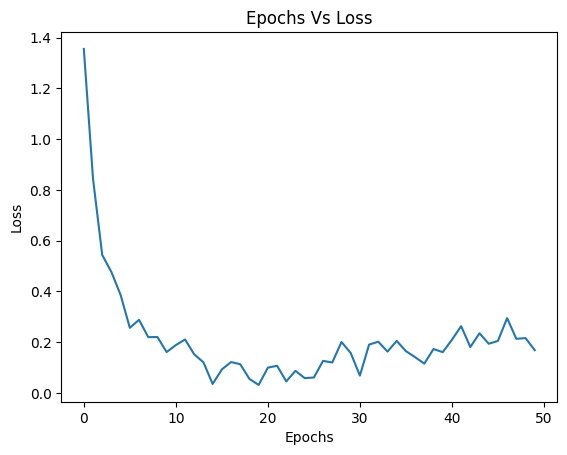

In [23]:
bert_model = BERTmodel().to(device)
epochs = 50
lossList=train(epochs,bert_model)
visualizeLoss(lossList)

In [81]:
evaluate(bert_model)

Accuracy: 93.65079365079364 %
F1 Score: 93.65079365079364 %
Precision: 93.65079365079364 %
